In [1]:
!pip install pyheif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 89.3 MB/s eta 0:00:00


In [14]:
from google.colab import drive
drive.mount('/gdrive')
data_dir = '/gdrive/MyDrive/project1/handwritten_digit_classification/DATA'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
import os
import glob

image_lists = []
for folder in glob.glob(f'{data_dir}/*/hand_written_digit/??52????'):
    for num in range(10):
        for img_path in glob.glob(f'{folder}/{num}_*'):
            image_lists.append((img_path, num))

print("Sample of image_lists:")
for item in image_lists[:5]:
    print(item, type(item), len(item))

Sample of image_lists:
('/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/GwLewis369_Hand-written-digit-classification-data/hand_written_digit/22520369/0_image132.jpg', 0) <class 'tuple'> 2
('/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/GwLewis369_Hand-written-digit-classification-data/hand_written_digit/22520369/0_image87.jpg', 0) <class 'tuple'> 2
('/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/GwLewis369_Hand-written-digit-classification-data/hand_written_digit/22520369/0_image39.jpg', 0) <class 'tuple'> 2
('/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/GwLewis369_Hand-written-digit-classification-data/hand_written_digit/22520369/0_image131.jpg', 0) <class 'tuple'> 2
('/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/GwLewis369_Hand-written-digit-classification-data/hand_written_digit/22520369/0_image36.jpg', 0) <class 'tuple'> 2


In [4]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import pyheif
import io

class custom_image_dataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path, label = self.image_list[idx]
        ext = os.path.splitext(img_path)[1].lower()

        try:
            if ext == '.heic':
                heif_file = pyheif.read(img_path)
                image = Image.frombytes(
                    heif_file.mode,
                    heif_file.size,
                    heif_file.data,
                    "raw",
                    heif_file.mode,
                    heif_file.stride,
                )
                image = image.convert('RGB')
            else:
                image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label), img_path
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            raise ValueError(f"Cannot read image: {img_path}")

In [5]:
from concurrent.futures import ThreadPoolExecutor
import os
from PIL import Image
import pyheif
import io

def is_valid_image(item):
    path, label = item
    if not os.path.isfile(path):
        print(f"Invalid file (does not exist): {path}")
        return None

    ext = os.path.splitext(path)[1].lower()

    supported_extensions = ['.jpg', '.jpeg', '.png', '.heic']

    if ext not in supported_extensions:
        print(f"Invalid image (unsupported extension): {path}")
        return None

    try:
        if ext == '.heic':
            heif_file = pyheif.read(path)
            if heif_file:
                return (path, label)
            else:
                print(f"Invalid HEIC image: {path}")
                return None
        else:
            with Image.open(path) as img:
                img.verify()
            return (path, label)
    except Exception as e:
        print(f"Error validating image {path}: {e}")
        return None

with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(is_valid_image, image_lists))

valid_image_lists = [r for r in results if r is not None]
print(f"Total valid images: {len(valid_image_lists)}")

Invalid image (unsupported extension): /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/anhtuann1224_hand_written_digit/hand_written_digit/23520886/0_1_blue.jfif
Invalid image (unsupported extension): /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/anhtuann1224_hand_written_digit/hand_written_digit/23520886/0_1_red.jfif
Invalid image (unsupported extension): /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/anhtuann1224_hand_written_digit/hand_written_digit/23520886/0_3_red.jfif
Invalid image (unsupported extension): /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/anhtuann1224_hand_written_digit/hand_written_digit/23520886/0_2_red.jfif
Invalid image (unsupported extension): /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/anhtuann1224_hand_written_digit/hand_written_digit/23520886/0_5_red.jfif
Invalid image (unsupported extension): /gdrive/MyDrive/project1/handwritten_digit_classification/DATA/anhtuann1224_hand_writ

In [8]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

# Sử dụng mean và std từ Cell 1 (thay bằng placeholder nếu lỗi)
mean = [0.485, 0.456, 0.406]  # Placeholder
std = [0.229, 0.224, 0.225]    # Placeholder
if 'mean' in globals():
    mean = globals()['mean']
    std = globals()['std']

# Định nghĩa biến đổi
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=mean, std=std)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=mean, std=std)
])

split = int(0.8 * len(valid_image_lists))
train_dataset = custom_image_dataset(valid_image_lists[:split], train_transform)
test_dataset = custom_image_dataset(valid_image_lists[split:], test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)



# Kiểm tra Dataset
try:
    img, label, path = train_dataset[0]
    print(f"Train dataset mẫu: img_shape={img.shape}, label={label}, path={path}")
    img, label, path = test_dataset[0]
    print(f"Test dataset mẫu: img_shape={img.shape}, label={label}, path={path}")
except Exception as e:
    print(f"Lỗi khi truy cập Dataset: {e}")

# Tạo DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

Train dataset mẫu: img_shape=torch.Size([3, 224, 224]), label=0, path=/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/GwLewis369_Hand-written-digit-classification-data/hand_written_digit/22520369/0_image132.jpg
Test dataset mẫu: img_shape=torch.Size([3, 224, 224]), label=3, path=/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/Lochke_CS114_Handwritten_Digit_Classification/hand_written_digit/22520791/3_R_002.png


In [21]:
# Định nghĩa mô hình
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Khởi tạo mô hình
model = ConvNeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Kiểm tra tham số mô hình
print(f"Model initialized on {device}")
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Model initialized on cuda
Number of trainable parameters: 25698122


Epoch 1
-------------------------------
[Batch 20] loss: 9.595
[Batch 40] loss: 2.302
[Batch 60] loss: 2.300
[Batch 80] loss: 2.303
Test: Accuracy: 5.8%, Avg loss: 2.313
Lưu mô hình tốt nhất tại epoch 1
Epoch 2
-------------------------------
[Batch 20] loss: 2.298
[Batch 40] loss: 2.295
[Batch 60] loss: 2.291
[Batch 80] loss: 2.287
Test: Accuracy: 6.2%, Avg loss: 2.309
Lưu mô hình tốt nhất tại epoch 2
Epoch 3
-------------------------------
[Batch 20] loss: 2.290
[Batch 40] loss: 2.291
[Batch 60] loss: 2.289
[Batch 80] loss: 2.290
Test: Accuracy: 5.9%, Avg loss: 2.313
Epoch 4
-------------------------------
[Batch 20] loss: 2.292
[Batch 40] loss: 2.280
[Batch 60] loss: 2.291
[Batch 80] loss: 2.288
Test: Accuracy: 4.8%, Avg loss: 2.318
Epoch 5
-------------------------------
[Batch 20] loss: 2.287
[Batch 40] loss: 2.285
[Batch 60] loss: 2.285
[Batch 80] loss: 2.275
Test: Accuracy: 4.7%, Avg loss: 2.328
Epoch 6
-------------------------------
[Batch 20] loss: 2.284
[Batch 40] loss: 2.28

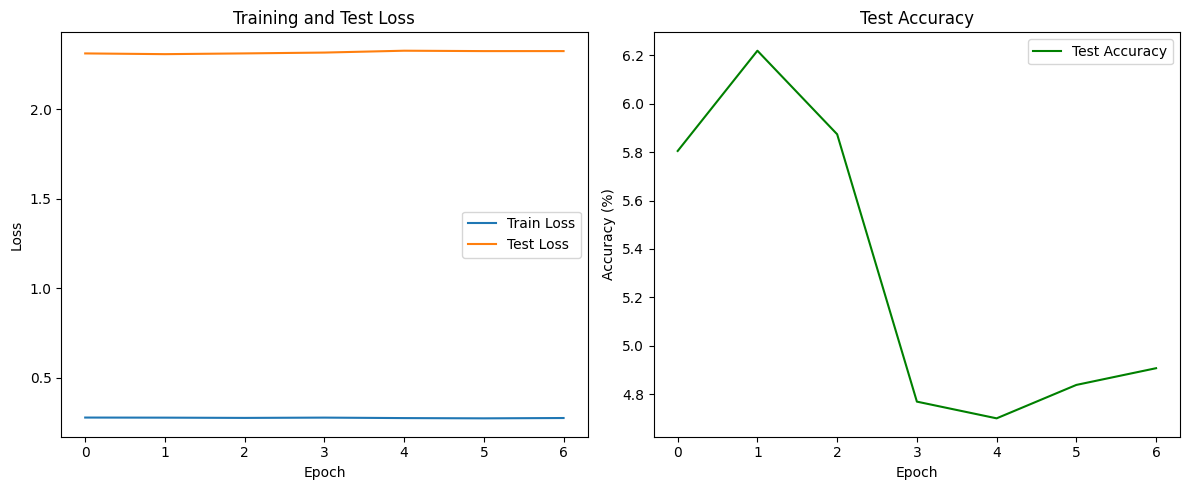

Hoàn thành huấn luyện!


<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt
import os

# Hàm huấn luyện
def train_loop(dataloader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels, _) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 19:
            print(f'[Batch {i + 1}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0
    return running_loss / len(dataloader)

# Hàm kiểm tra
def test_loop(dataloader, model, criterion):
    model.eval()
    total = 0
    correct = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(dataloader)
    accuracy = 100 * correct / total
    print(f'Test: Accuracy: {accuracy:.1f}%, Avg loss: {test_loss:.3f}')
    return test_loss, accuracy

# Huấn luyện
train_losses = []
test_losses = []
test_accuracies = []
best_loss = float('inf')
epochs_no_improve = 0
output_dir = '/gdrive/MyDrive/CS114/handwritten_digit_classification/NguyenHaiThien/Model1'
os.makedirs(output_dir, exist_ok=True)
best_model_path = os.path.join(output_dir, 'best_model1.pth')
epochs = 20
patience = 5

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}\n-------------------------------')
    train_loss = train_loop(train_dataloader, model, criterion, optimizer)
    test_loss, test_accuracy = test_loop(test_dataloader, model, criterion)
    scheduler.step()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Lưu mô hình tốt nhất tại epoch {epoch+1}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping tại epoch {epoch + 1}')
            break

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

print('Hoàn thành huấn luyện!')
model.load_state_dict(torch.load(best_model_path))

In [ ]:
import os
from PIL import Image
import pillow_heif

# Đường dẫn
test_data_dir = '/gdrive/MyDrive/CS114/handwritten_digit_classification/cs114.hwdr'

# Kiểm tra thư mục
if not os.path.exists(test_data_dir):
    raise FileNotFoundError(f"Thư mục {test_data_dir} không tồn tại. Vui lòng kiểm tra:\n"
                            f"!ls /gdrive/MyDrive/CS114/handwritten_digit_classification")

# Lấy danh sách ảnh hợp lệ
test_image_paths = []
for file in os.listdir(test_data_dir):
    file_path = os.path.join(test_data_dir, file)
    try:
        if file.lower().endswith('.heic'):
            heif_file = pillow_heif.read_heif(file_path)
            test_image_paths.append(file_path)
        else:
            img = Image.open(file_path)
            img.verify()
            img.close()
            test_image_paths.append(file_path)
    except Exception as e:
        print(f"Bỏ qua file không phải ảnh: {file_path} ({str(e)})")

print(f"Tìm thấy {len(test_image_paths)} file ảnh hợp lệ.")
print("Ví dụ 5 file đầu tiên:", test_image_paths[:5])

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

# Định nghĩa TestImageDataset
class TestImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            if img_path.lower().endswith('.heic'):
                heif_file = pillow_heif.read_heif(img_path)
                image = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data)
            else:
                image = Image.open(img_path)
            image = image.convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, img_path
        except Exception as e:
            print(f"Lỗi khi đọc file {img_path}: {str(e)}")
            return torch.zeros((3, 224, 224)), img_path

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=mean, std=std)
])

# Tạo Dataset và DataLoader
test_dataset = TestImageDataset(test_image_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Tải mô hình
model_path = '/gdrive/MyDrive/CS114/handwritten_digit_classification/NguyenHaiThien/Model2/best_model1.pth'
model = ConvNeuralNetwork()
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# Dự đoán
predictions = []
with torch.no_grad():
    for images, img_paths in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for img_path, pred in zip(img_paths, predicted):
            filename = os.path.basename(img_path)
            predictions.append((filename, pred.item()))

print(f"Đã dự đoán xong cho {len(predictions)} ảnh.")

In [ ]:
import csv
import os

output_csv = '/gdrive/MyDrive/CS114/handwritten_digit_classification/NguyenHaiThien/Model2/predictions.csv'
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for filename, label in predictions:
        writer.writerow([filename, label])

print(f"Kết quả đã được lưu vào {output_csv}")

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = '/gdrive/MyDrive/project1/handwritten_digit_classification/DATA/best_model1.pth'
model = ConvNeuralNetwork()
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict, strict=True)
model.to(device)
model.eval()

print("Mô hình Model 1 đã được load!")

Mô hình Model 1 đã được load!


In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Evaluation Metrics:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Metric,Score
0,Accuracy,0.096012
1,F1-score,0.016821
2,Precision,0.009218
3,Recall,0.096012


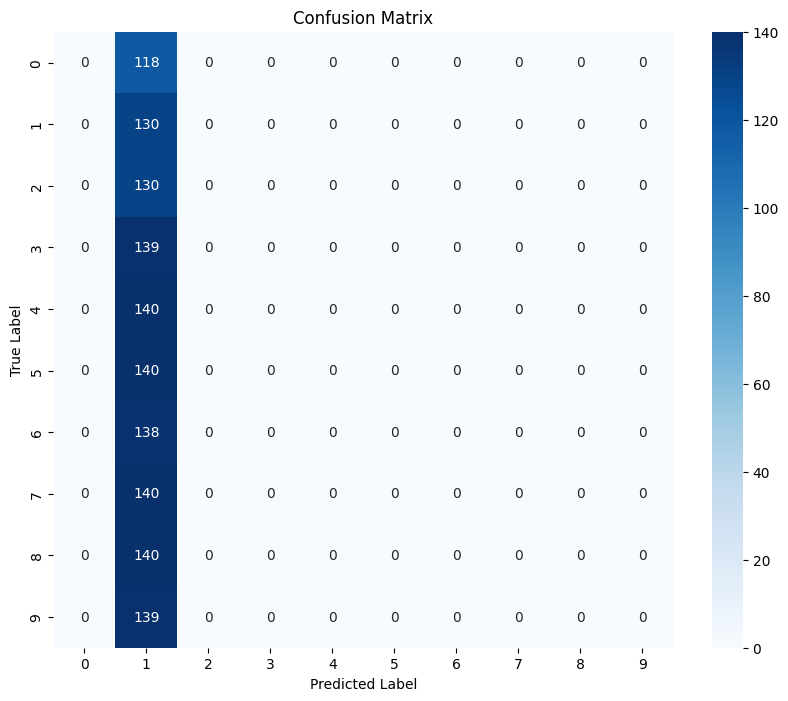

In [26]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for images, labels, _ in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

metrics_data = {'Metric': ['Accuracy', 'F1-score', 'Precision', 'Recall'],
                'Score': [accuracy, f1, precision, recall]}
metrics_df = pd.DataFrame(metrics_data)
print("Evaluation Metrics:")
display(metrics_df)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()